# Taxi orders prediction

The YellowTaxi company has collected historical data on taxi orders at airports. To attract more drivers during peak load period, we need to predict the number of taxi orders for the next hour. The challenge is to build a model for this prediction with the final <code>RMSE</code> score less than <code>48</code>

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
import matplotlib as mpl

import os 

import matplotlib.patches as mpatches
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

from sklearn.metrics import (
    mean_squared_error,
    make_scorer,
    mean_absolute_error,
    
)
from sklearn.model_selection import TimeSeriesSplit

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')

## Plan
1. [Overview and preprocessing](#review)
2. [Add features](#featureEngineering)
5. [Model exploration](#MLmodelResearch)
6. [Results](#resultsRearchModel)
7. [Overall results](#results)

<a id="review"></a>
# Overview and preprocessing

In [2]:
cwd = os.getcwd()
try:
    df = pd.read_csv(cwd + '/taxi.csv')
except:
    df = pd.read_csv('/datasets/taxi.csv')

In [3]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [4]:
df.set_index('datetime')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
df

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

Let's resample to each hour instead of each 10 mins

In [7]:
dfh = df.resample('1H').sum()

In [8]:
dfh = dfh.sort_index()

In [9]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
def simple_plot(df, title, xlabel, ylabel):
    plt.figure(figsize=(15,7))
    sns.lineplot(data=df);
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

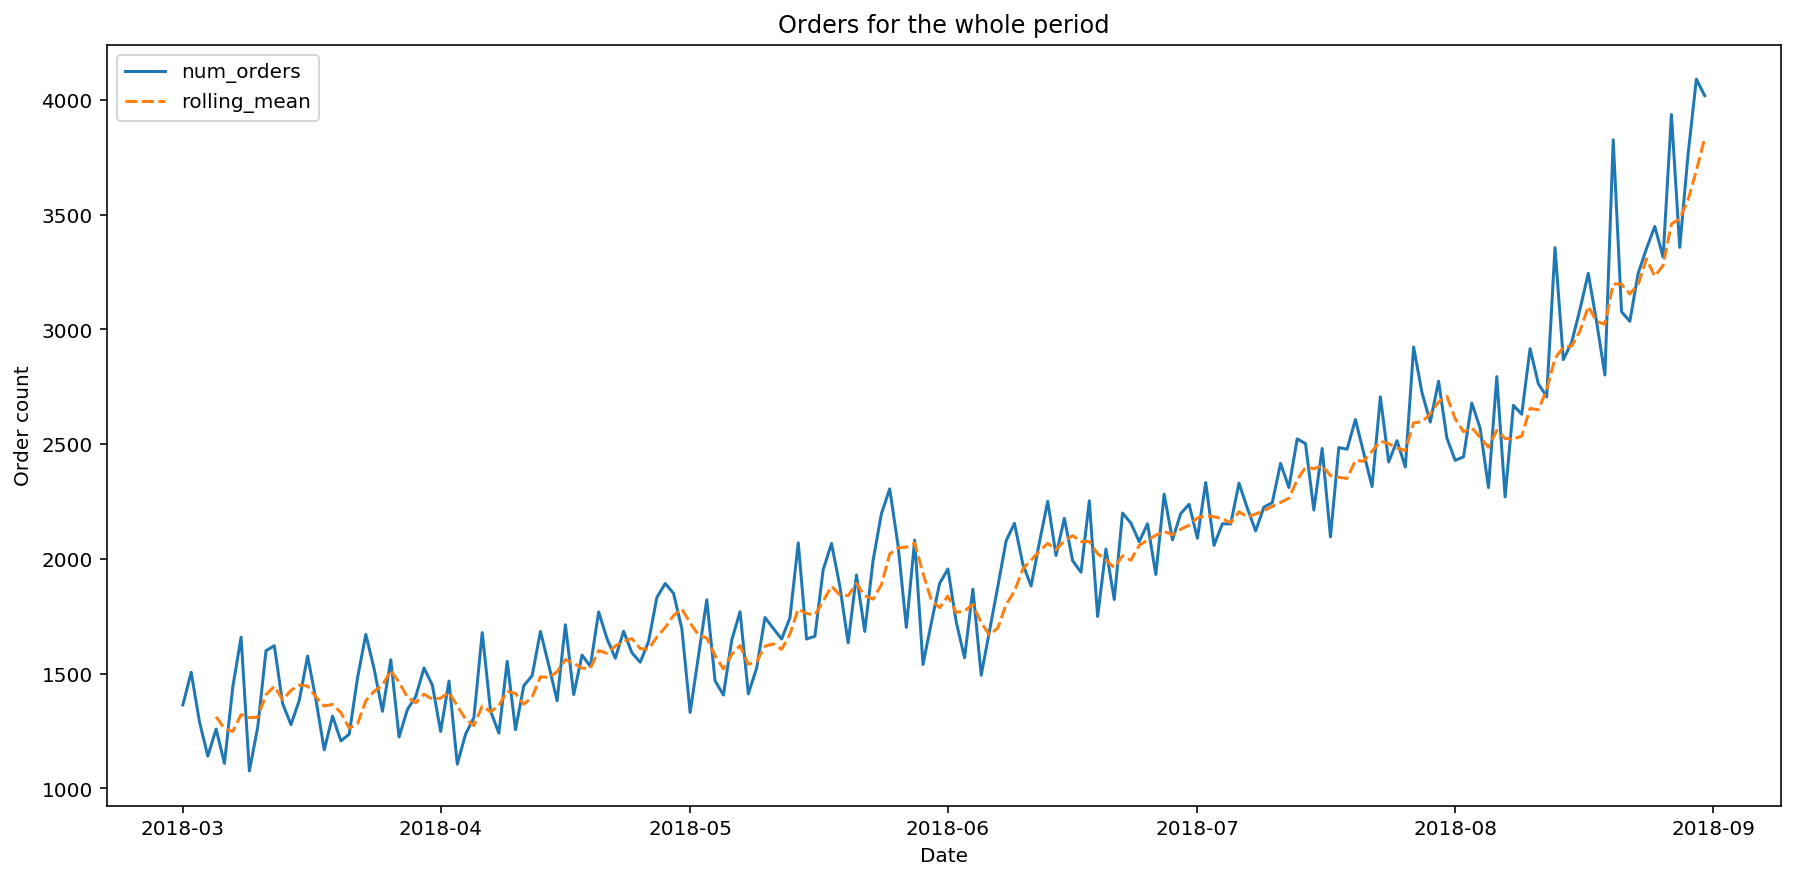

In [11]:
df_for_graph = dfh.resample('1D').sum()
df_for_graph['rolling_mean'] = df_for_graph.rolling(5).mean()
simple_plot(df_for_graph, 'Orders for the whole period', 'Date', 'Order count')

Let's do a seasonal decompose

In [12]:
dfh = dfh.dropna()

In [13]:
dfh

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [14]:
seasonal = seasonal_decompose(dfh['num_orders'])

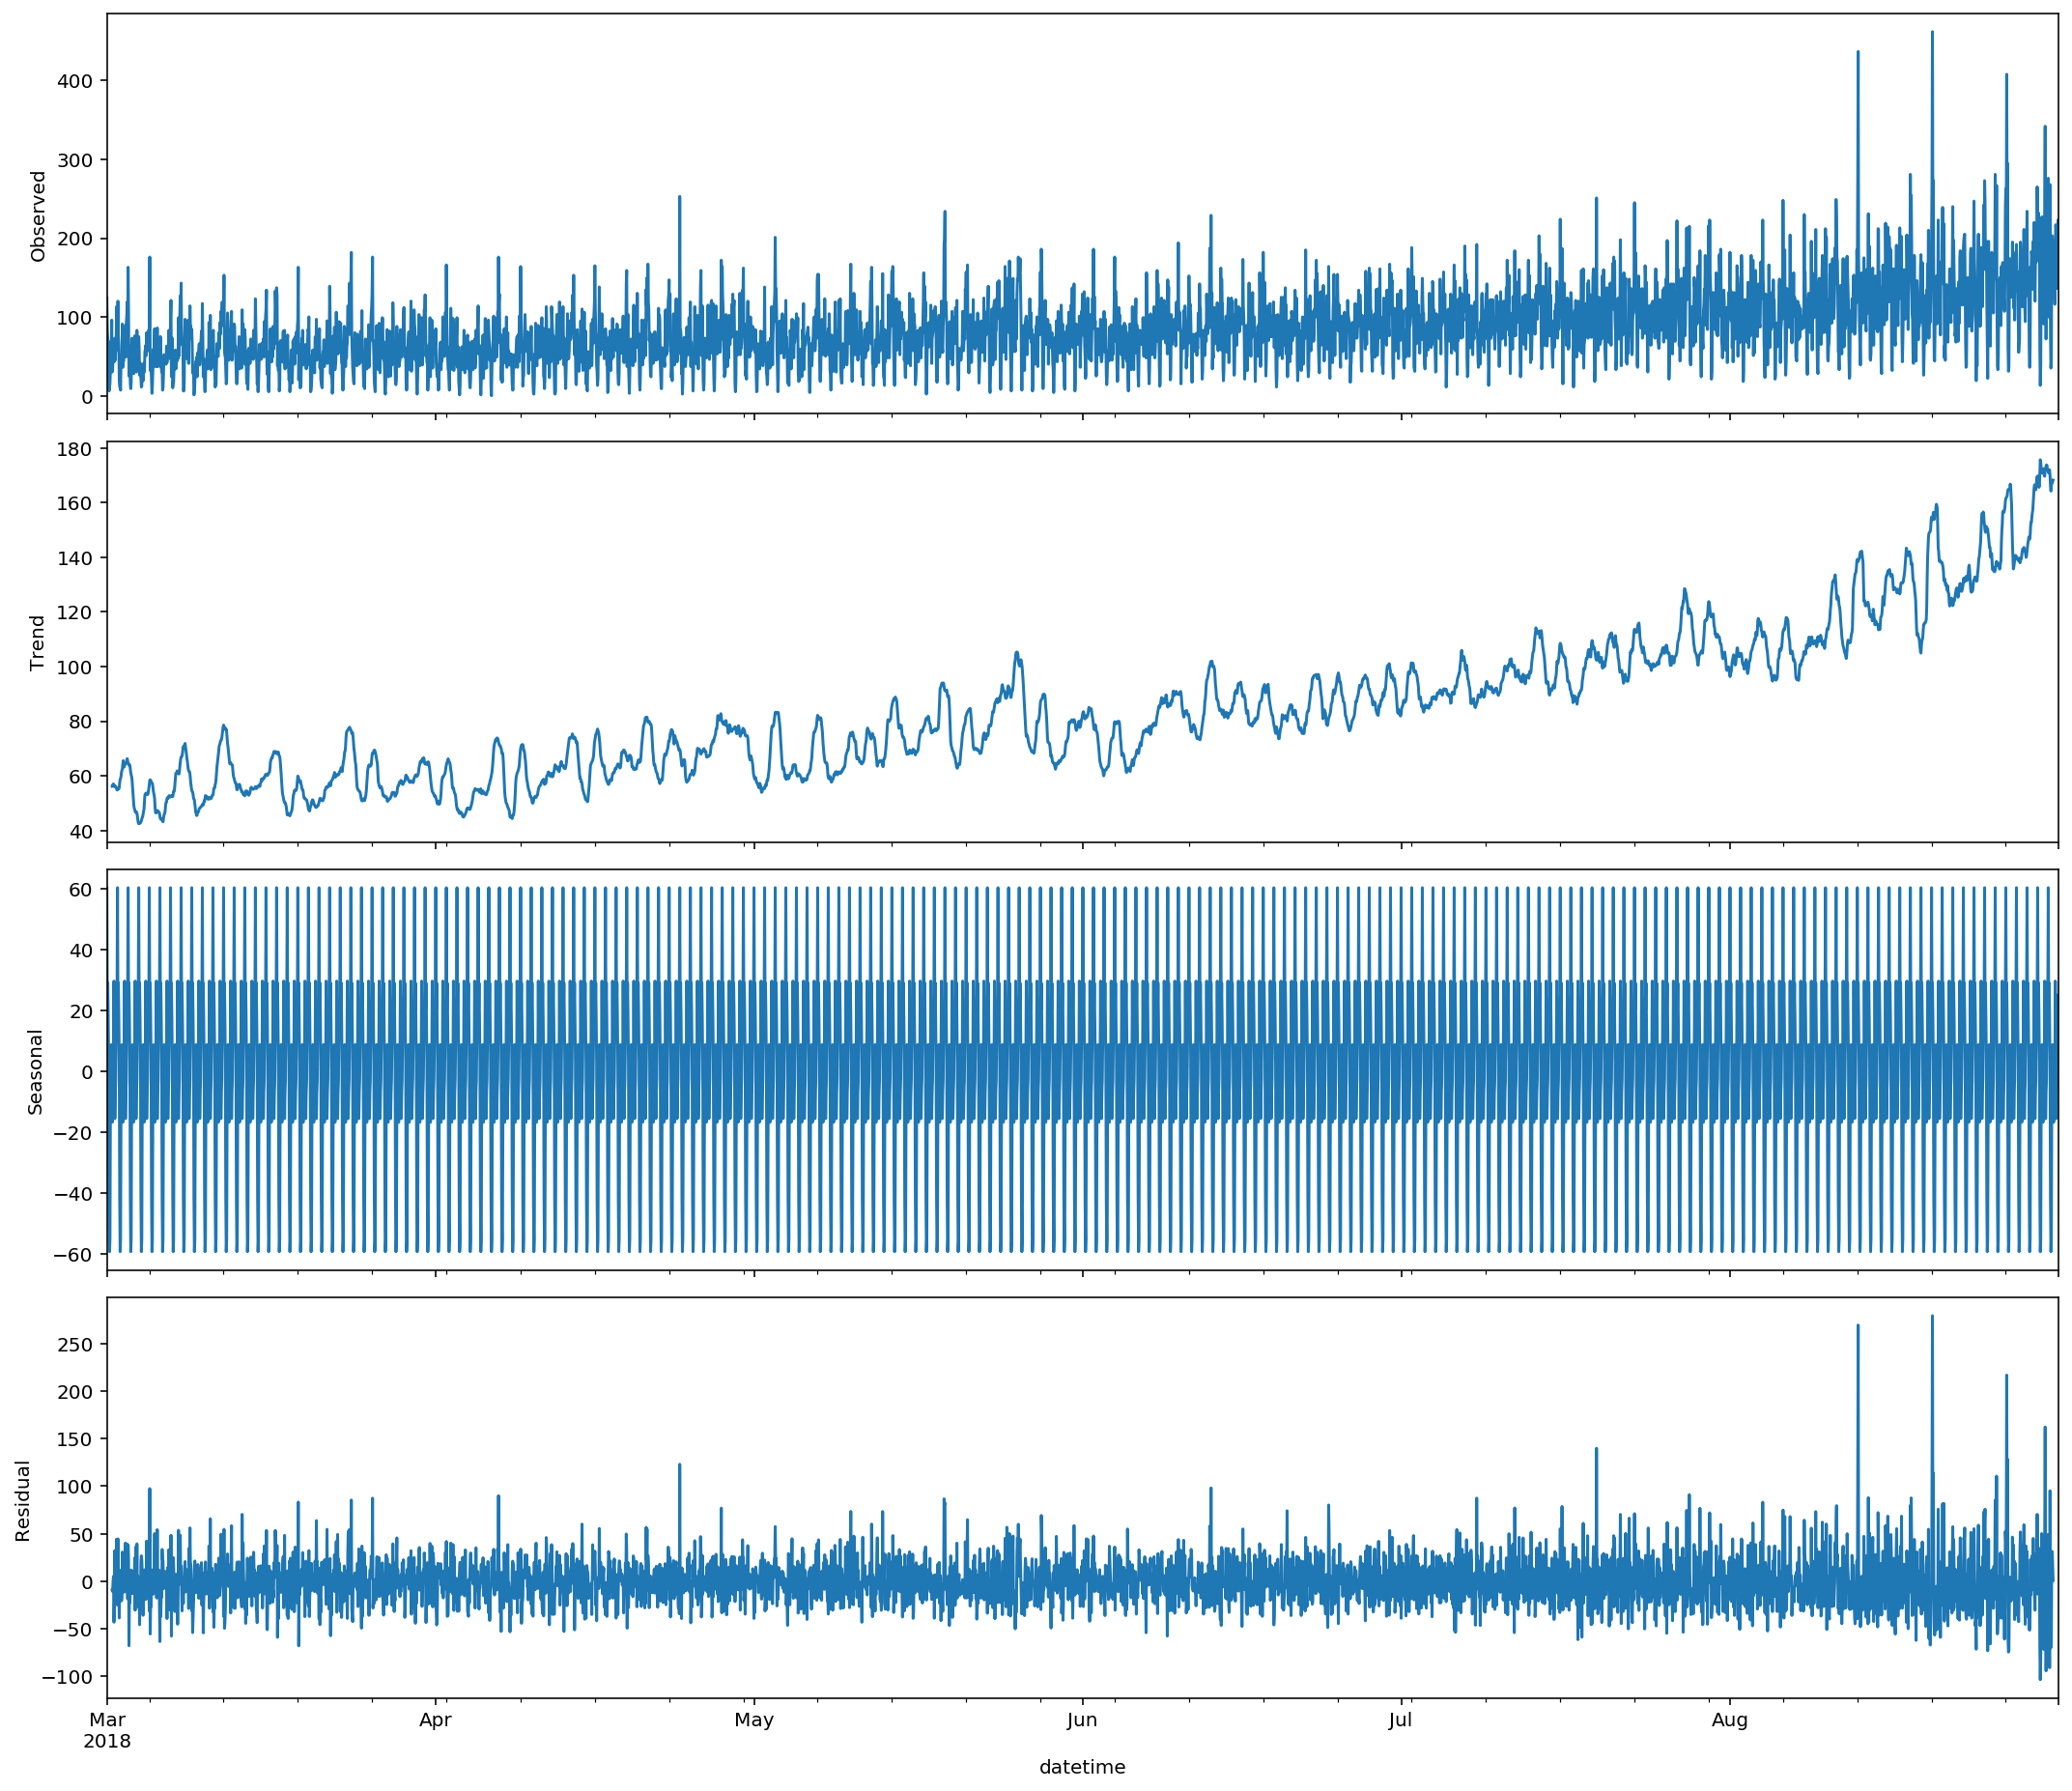

In [15]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,13))
    seasonal.plot()

We see the overall count of orders increases with time

In [16]:
month_df = dfh['2018-06-01': '2018-06-15']

In [17]:
seasonal_month = seasonal_decompose(month_df['num_orders'])

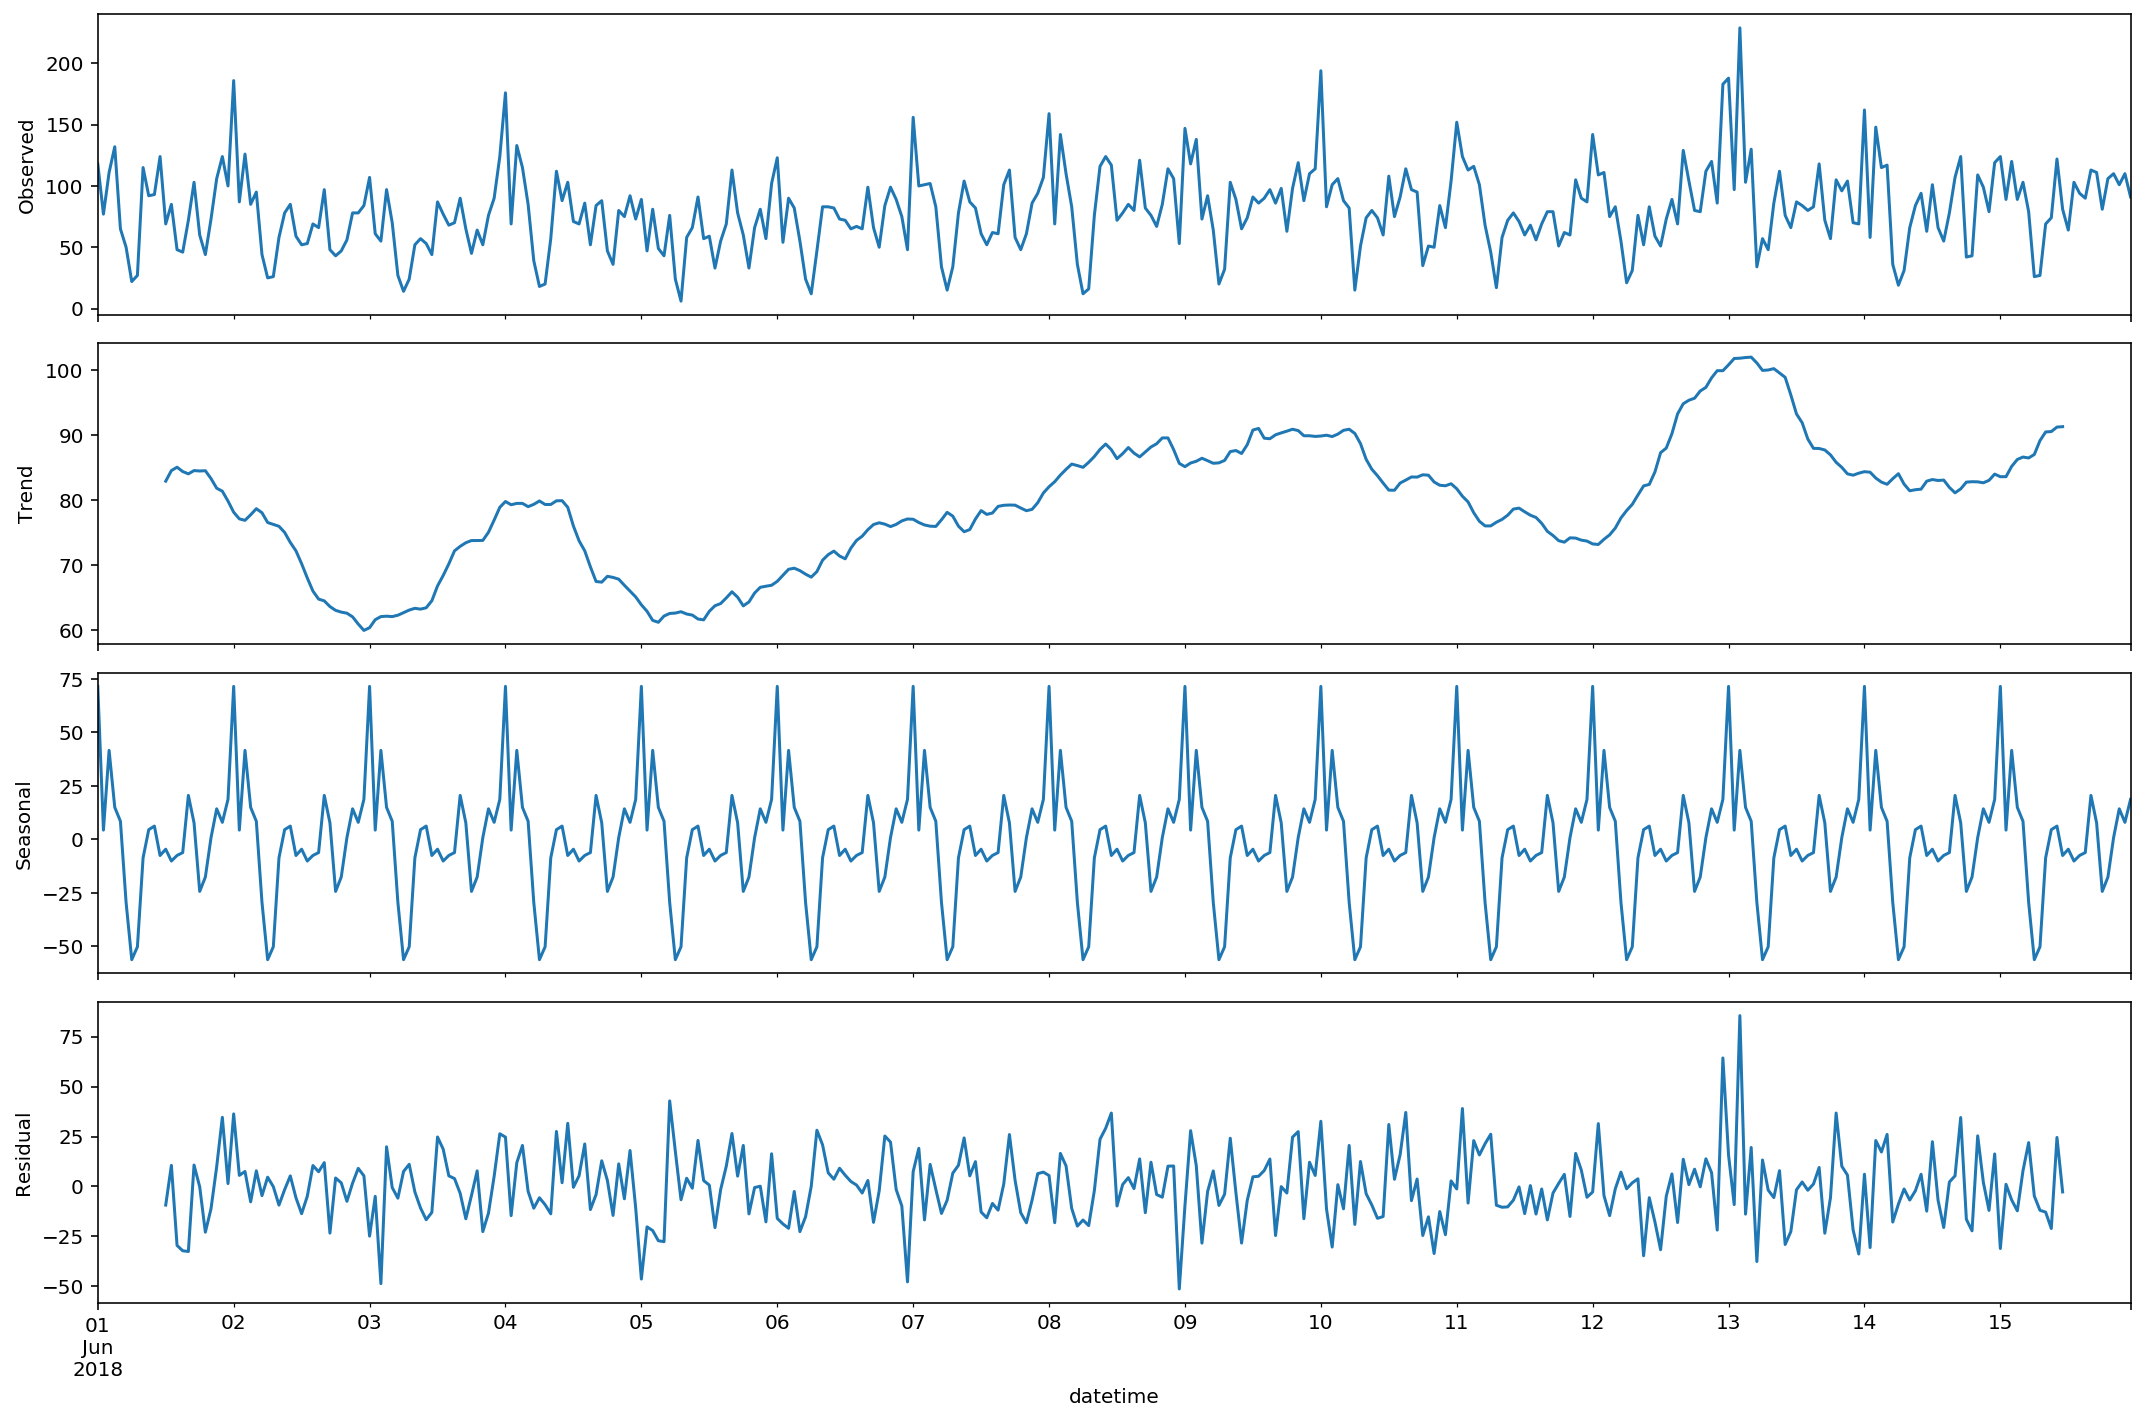

In [18]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(15,10))
    seasonal_month.plot()

## Conclusion

- The total number of orders grows over time
- On Saturday and Monday the number of orders is the least
- Peak orders are from Tuesday to Friday

<a id="featureEngineering"></a>
# Adding features

To ease the task for the models let's add some features

- Calendar  
- Lag

In [19]:
def add_features(dataframe, max_lag, rolling_mean_size):
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df.index.weekday.isin([5,6])*1
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df
    

In [20]:
data = add_features(dfh, 6, 5)

In [21]:
data

,num_orders,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,0,19,207.0,217.0,197.0,116.0,133.0,166.0,174.0
2018-08-31 20:00:00,154,4,0,20,136.0,207.0,217.0,197.0,116.0,133.0,174.6
2018-08-31 21:00:00,159,4,0,21,154.0,136.0,207.0,217.0,197.0,116.0,182.2


In [22]:
data.head()

,num_orders,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN


In [23]:
data = data.dropna()

In [24]:
features, target = data.drop('num_orders', axis=1), data['num_orders']

In [25]:
features.shape, target.shape

((4410, 10), (4410,))

In [26]:
X, Xt, y, yt = train_test_split(features, target, test_size=0.1, shuffle=False)

In [27]:
X.shape, y.shape, Xt.shape, yt.shape

((3969, 10), (3969,), (441, 10), (441,))

<a id="MLmodelResearch"></a>
# Looking for the best model

We'll chose between:

- Linear Regression
- Random Forest
- LightGBM


## Linear Regression

In [28]:
def rmse(target, pred):
    return mean_squared_error(target, pred) ** 0.5

rmse_ = make_scorer(rmse, greater_is_better=False)

In [29]:
def mape(y, p):
    return 100 *(sum(abs((y-p)/y) / len(y)))

In [30]:
linear_model = LinearRegression()
linear_model.fit(X, y)
prediction = linear_model.predict(Xt)

In [31]:
print(f'MAPE : {mape(yt, prediction)}')
print(f'RMSE : {mean_squared_error(yt, prediction) **0.5}')

MAPE : 36.0228416384111
RMSE : 55.44386982040144


<code> RMSE for Linear Regression = 55.44. On average it is mistaken by 55 orders. MAPE -> 36% mistake rate </code>

## Random Forest

In [32]:
split = TimeSeriesSplit( max_train_size=None, n_splits=3)

In [196]:
# param_grid = {
#     'max_depth': [80, 90, 100],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [200, 300, 1000]
# }



# rf = RandomForestRegressor()

# grid_forest = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = split, n_jobs = -1, verbose = 0, scoring=rmse_)

# grid_forest.fit(X,y)
# prediction = grid_forest.predict(Xt)

In [34]:
# grid_forest.best_estimator_

In [36]:
print(f'MAPE : 28.70')
print(f'RMSE : 53.25')

MAPE : 28.70
RMSE : 53.25


## LightGBM

In [37]:
# lgbm_params = {
#     'num_leaves': [100, 500, 1000],
#     'max_depth': [4, 6, 10],
#     'n_estimators': [150, 300, 1000],
#     'learning_rate': [0.05, 0.15, 0.3]
# }

# lgbm = LGBMRegressor()

# grid_lgbm = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, 
#                           cv = split, n_jobs = -1, verbose = 1, scoring=rmse_)

# grid_lgbm.fit(X, y)

# lgbm_prediction = grid_lgbm.predict(Xt)


In [38]:
best_lgbm = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=100, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
best_lgbm.fit(X, y)
lgbm_pred = best_lgbm.predict(Xt)

In [42]:
print('MAPE : 26.55')
print('RMSE : 46.81')

MAPE : 26.55
RMSE : 46.81


## Dummy

In [203]:
dummy_model = DummyRegressor(strategy="constant", constant=y.median())
dummy_model.fit(X, y)
prediction = dummy_model.predict(Xt)

In [204]:
print(f'MAPE : {mape(yt, prediction)}')
print(f'RMSE : {mean_squared_error(yt, prediction)**0.5}')

MAPE : 49.14218941435529
RMSE : 87.24205906985632


## Previous value of the series

In [43]:
pred_previous = yt.shift()

In [44]:
pred_previous.iloc[0] = yt.iloc[-1]

In [45]:
print(f'MAPE : {mape(yt, pred_previous)}')
print(f'RMSE : {mean_squared_error(yt,  pred_previous)**0.5}')

MAPE : 39.7091418843255
RMSE : 58.83232640636853


# Comparing the predictions of our best model with true values

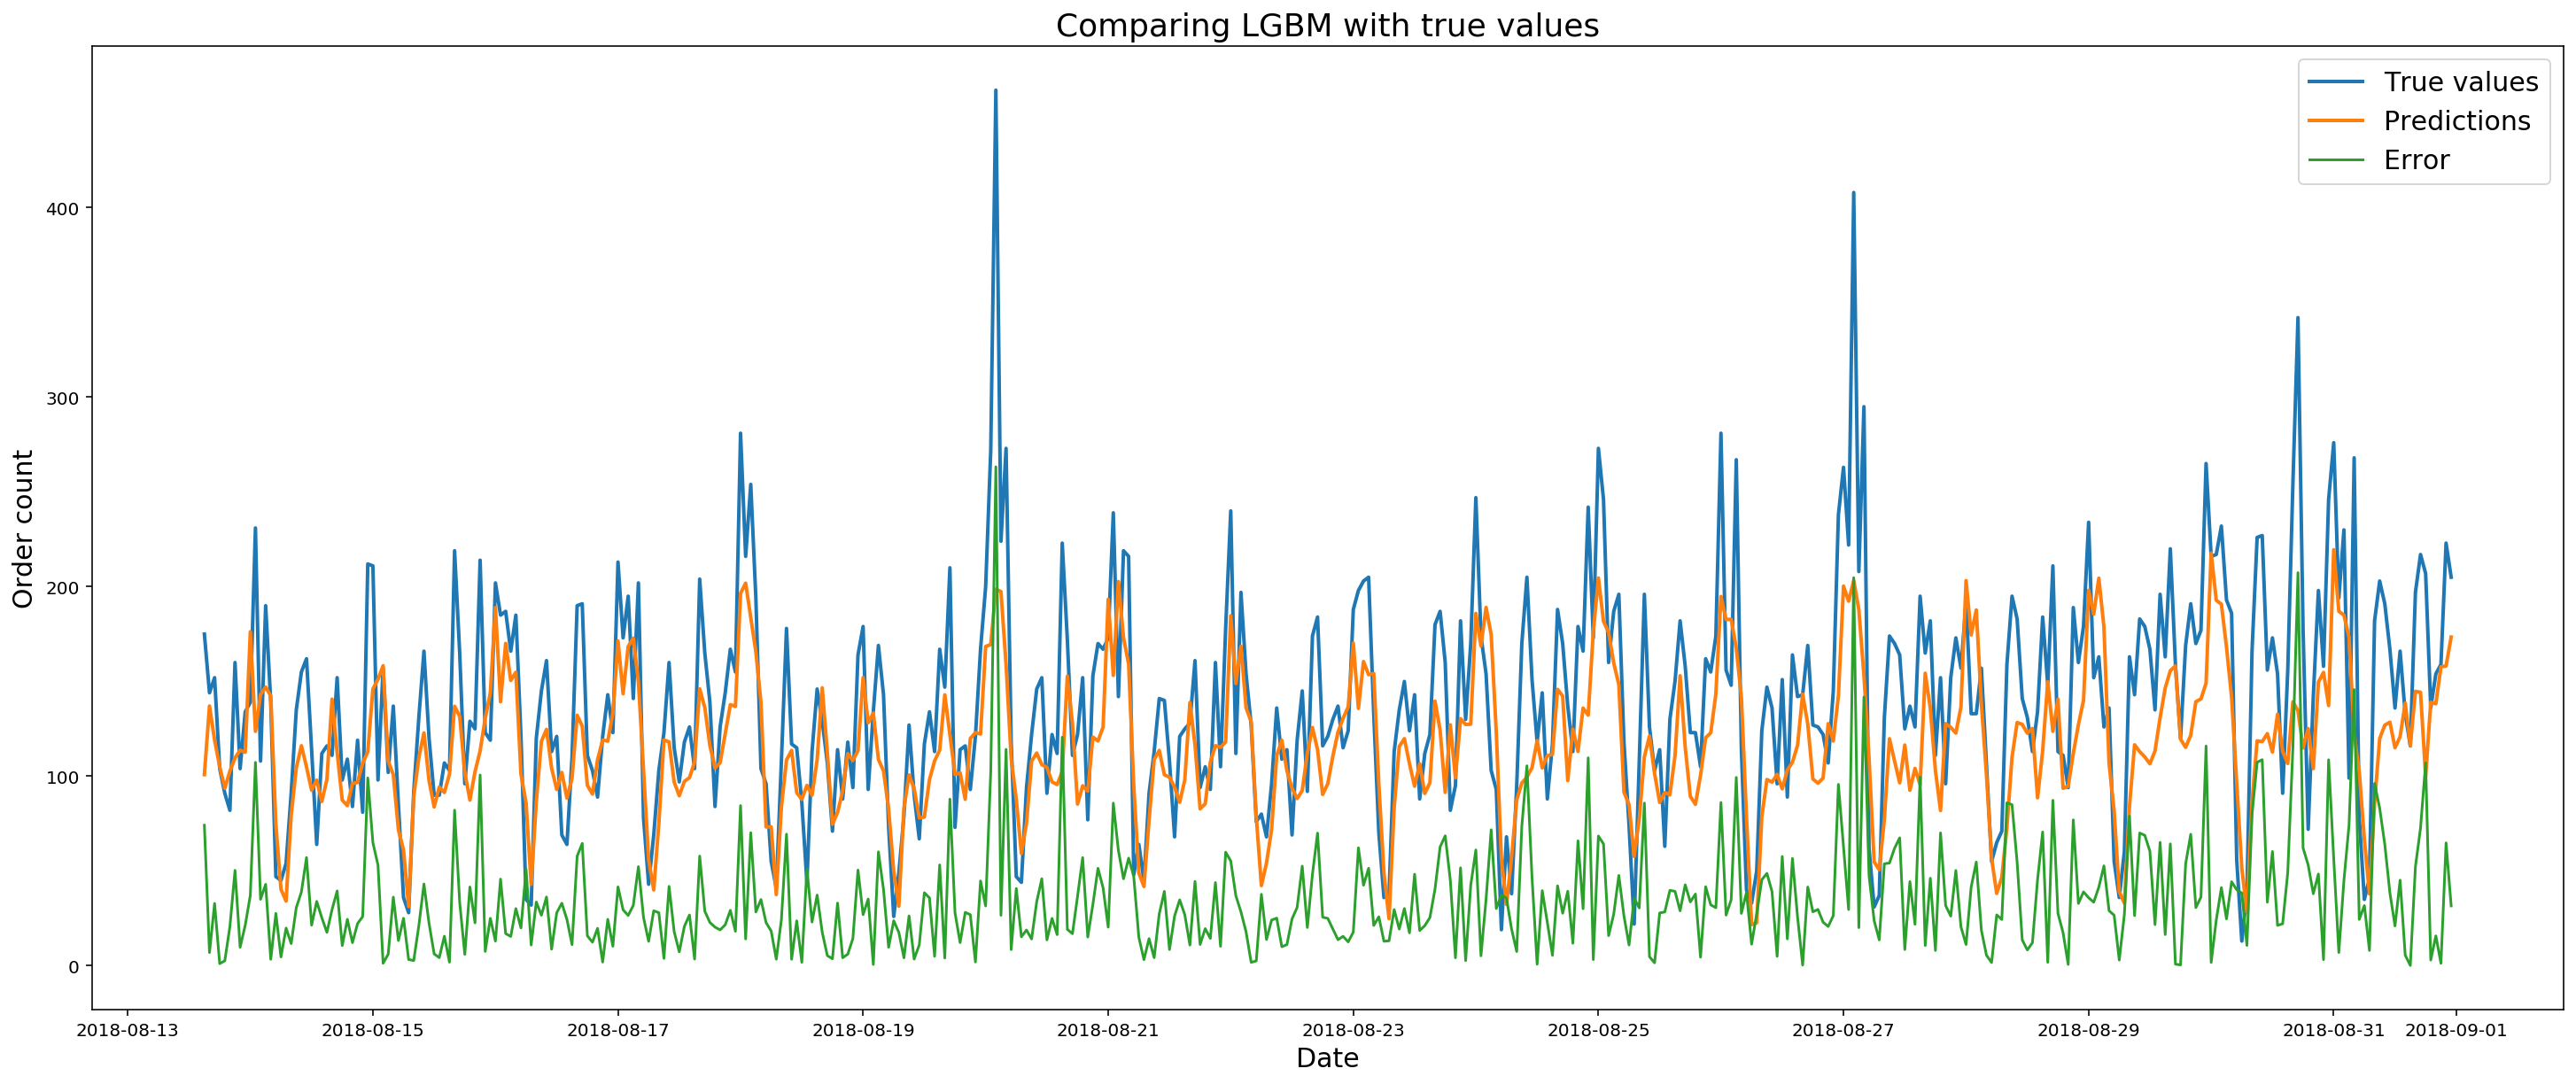

In [46]:
plt.figure(figsize=(25, 10))

sns.lineplot(Xt.index, yt, linewidth = 2)
sns.lineplot(Xt.index, lgbm_pred, linewidth = 2);
sns.lineplot(Xt.index, abs(yt -lgbm_pred))

plt.title('Comparing LGBM with true values', size=18)
plt.xlabel('Date', size=15)
plt.ylabel('Order count', size=15)

plt.legend(['True values', 'Predictions', 'Error'], prop={'size': 15});


It can be seen that the model follows the cycles and different variations but is periodically more or less delayed. The error grows especially strongly on sharp jumps. If we had 10 times more data, I think the model would have worked much better

## Conclusion

Result:
- Linear regression showed <code> MAPE: 36.02, RMSE: 55.44 </code >
- Forest showed <code> MAPE: 28.84, RMSE: 53.36 </code >
- LGBM showed <code> MAPE: 26.55, RMSE: 46.81 </code >
- Prediction through previous value showed <code> MAPE: 39.70 RMSE: 58.83 </code >
- Constant predictions showed <code> MAPE: 49.14, RMSE: 87.24 </code >

The best model was LGBM with <code> RMSE 46.8 </code > that meets the task requirement